In [1]:
import warnings
warnings.filterwarnings("ignore")
from env import host, user, password
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_selection import chi2, SelectKBest
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text, export_graphviz
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
import os
import acquire
import prepare

In [2]:
# Acquire Data
df = acquire.get_telco_db('telco_churn')

In [3]:
df.head()

,payment_type_id,contract_type_id,internet_service_type_id,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,...,tech_support,streaming_tv,streaming_movies,paperless_billing,monthly_charges,total_charges,churn,internet_service_type,contract_type,payment_type
0,2,1,3,0030-FNXPP,Female,0,No,No,3,Yes,...,No internet service,No internet service,No internet service,No,19.85,57.2,No,None,Month-to-month,Mailed check
1,2,1,3,0031-PVLZI,Female,0,Yes,Yes,4,Yes,...,No internet service,No internet service,No internet service,No,20.35,76.35,Yes,None,Month-to-month,Mailed check
2,1,1,3,0098-BOWSO,Male,0,No,No,27,Yes,...,No internet service,No internet service,No internet service,Yes,19.40,529.8,No,None,Month-to-month,Electronic check
3,1,1,3,0107-WESLM,Male,0,No,No,1,Yes,...,No internet service,No internet service,No internet service,Yes,19.85,19.85,Yes,None,Month-to-month,Electronic check
4,3,1,3,0114-RSRRW,Female,0,Yes,No,10,Yes,...,No internet service,No internet service,No internet service,Yes,19.95,187.75,No,None,Month-to-month,Bank transfer (automatic)


In [4]:
df.columns

Index(['payment_type_id', 'contract_type_id', 'internet_service_type_id',
       'customer_id', 'gender', 'senior_citizen', 'partner', 'dependents',
       'tenure', 'phone_service', 'multiple_lines', 'online_security',
       'online_backup', 'device_protection', 'tech_support', 'streaming_tv',
       'streaming_movies', 'paperless_billing', 'monthly_charges',
       'total_charges', 'churn', 'internet_service_type', 'contract_type',
       'payment_type'],
      dtype='object')

<AxesSubplot:xlabel='churn', ylabel='count'>

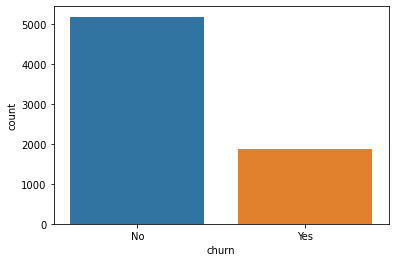

In [5]:
# Visualizing Churn
sns.countplot(df['churn'])

In [9]:
# Get percentages of churned and not churned

not_churned = df[df['churn']=='No']
churned = df[df['churn']=='Yes']

print(len(not_churned)/(len(churned)+len(not_churned)) * 100, '% of customers stayed with the company')
print(len(churned)/(len(churned)+len(not_churned)) * 100, '% of customers left the company')

73.42150170648463 % of customers stayed with the company
26.578498293515356 % of customers left the company


<AxesSubplot:xlabel='internet_service_type', ylabel='count'>

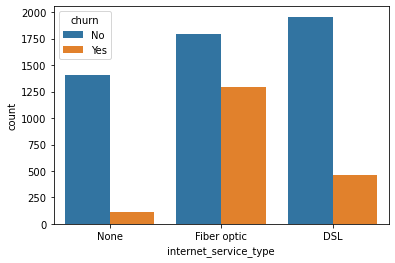

In [10]:
# Visualizing Churn by internet_service_type

sns.countplot(x='internet_service_type', hue='churn', data=df)

array([<AxesSubplot:title={'center':'tenure'}>,
       <AxesSubplot:title={'center':'monthly_charges'}>], dtype=object)

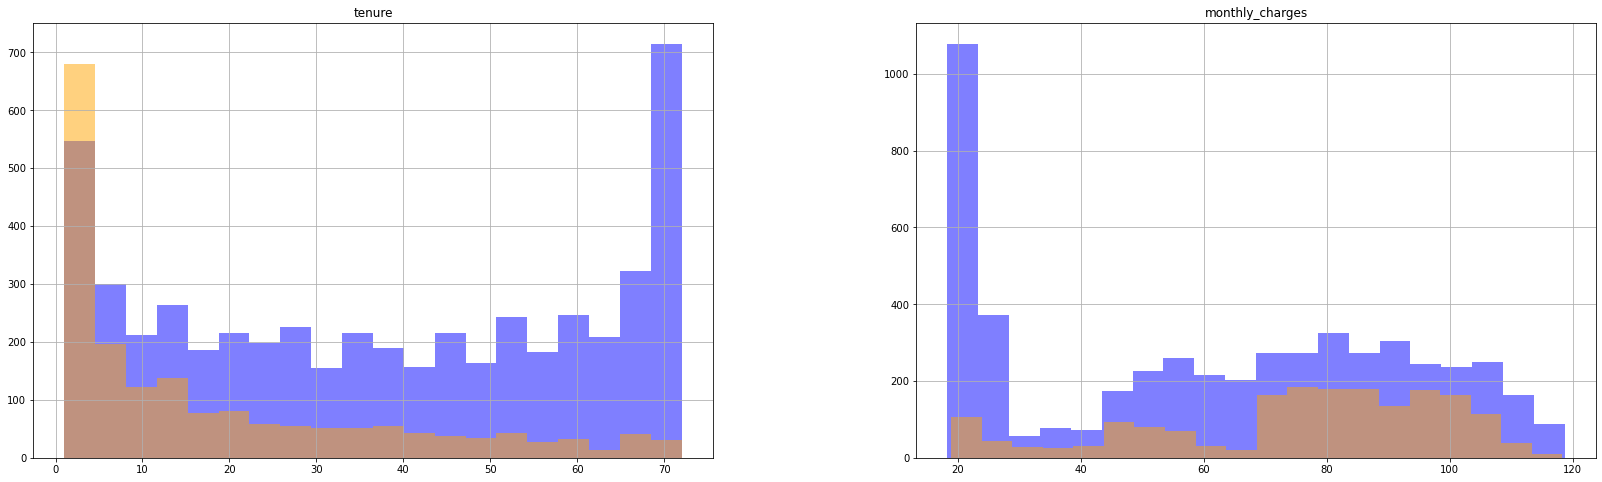

In [11]:
# Visualizing churn based on tenure and monthly_charges

features = ['tenure','monthly_charges']
fig, ax = plt.subplots(1, 2, figsize=(28,8))
not_churned[features].hist(bins=20, color='blue', alpha=0.5, ax = ax)
churned[features].hist(bins=20, color='orange', alpha=0.5, ax = ax)


In [ ]:
# Drop customer_id

df = df.drop(['customer_id','payment_type_id','contract_type_id','internet_service_type_id','online_backup','device_protection','tech_support','streaming_tv','streaming_movies'], axis = 1)

In [6]:
# Drop empty total row charges

df.drop(df[df['total_charges'].str.contains(" ")].index, inplace = True)

In [ ]:
df.shape

In [ ]:
sns.countplot(x='online_security', hue='churn', data=df)

<AxesSubplot:xlabel='total_charges', ylabel='count'>

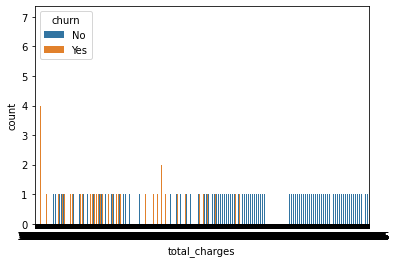

In [7]:
sns.countplot(x='total_charges', hue='churn', data=df)

In [ ]:
df.online_security.value_counts()

In [ ]:
no_security = df[df['online_security'] == 'No']
no_security.churn.value_counts()

In [ ]:
no_security.internet_service_type.value_counts()

In [ ]:
no_security[no_security['churn']=='Yes'].internet_service_type.value_counts()

In [ ]:
no_security[no_security['churn']=='No'].internet_service_type.value_counts()

In [ ]:
fiber = df[df['internet_service_type']=='Fiber optic']

In [ ]:
fiber['online_security'].value_counts()

In [ ]:
fiber[fiber['online_security']=='No'].churn.value_counts()

In [ ]:
fiber[fiber['online_security']=='Yes'].churn.value_counts()

In [ ]:
# Convert non-numeric columns to numeric

for column in df.columns:
    if df[column].dtype == np.number:
        continue
    df[column] = LabelEncoder().fit_transform(df[column])

In [ ]:
df.dtypes

In [ ]:
df.contract_type.value_counts()

In [ ]:
df.internet_service_type.value_counts()

In [ ]:
df.internet_service_type.value_counts()

In [ ]:
df.online_security.value_counts()

In [ ]:
df.churn.value_counts()

In [ ]:
def train_validate_test_split(df, target, seed=123):
    '''
    This function takes in a dataframe, the name of the target variable
    (for stratification purposes), and an integer for a setting a seed
    and splits the data into train, validate and test. 
    Test is 20% of the original dataset, validate is .30*.80= 24% of the 
    original dataset, and train is .70*.80= 56% of the original dataset. 
    The function returns, in this order, train, validate and test dataframes. 
    '''
    train_validate, test = train_test_split(df, test_size=0.2, 
                                            random_state=seed, 
                                            stratify=df[target])
    train, validate = train_test_split(train_validate, test_size=0.3, 
                                       random_state=seed,
                                       stratify=train_validate[target])
    return train, validate, test

In [ ]:
train, validate, test = train_validate_test_split(df, target='churn', seed=123)

In [ ]:
# Split the data
X_train = train.drop(columns=['churn'])
y_train = train.churn

X_validate = validate.drop(columns=['churn'])
y_validate = validate.churn

X_test = test.drop(columns=['churn'])
y_test = test.churn

### Hypothesis testing

In [ ]:
alpha = .05

#### Is there a correlation between month-to-month contracts and churn?
"$H_0$ = Churn is independent of month-to-month contracts"

"$H_a$ = Month-to-month contracts and churn are dependent on each other."

In [ ]:
observed = pd.crosstab(train['churn'], train['contract_type'])
chi2, p, degf, expected = stats.chi2_contingency(observed)

print(f"p value is less than alpha:  {p < alpha}")

#### Is there a correlation between fiber and churn
"$H_0$ = Churn is independent of fiber service."

"$H_a$ = Fiber service and churn are dependent on each other."

In [ ]:
observed = pd.crosstab(train.churn, train.internet_service_type)
chi2, p, degf, expected = stats.chi2_contingency(observed)

print(f"p value is less than alpha:  {p < alpha}")

In [ ]:
train.columns

In [ ]:
sns.heatmap(train.corr(), cmap='mako', center=0)

In [ ]:
X_train.columns

### Model 1

In [ ]:
# Create model
logit = LogisticRegression(C=1, random_state=123)
# Train model
logit.fit(X_train, y_train)

In [ ]:
def column_list(X_train):
    list = []
    for column in X_train.columns:
        list.append(column)
    return list

column_list(X_train)

In [ ]:
# Feature Importance
print('Coefficient: \n', logit.coef_)
print('Intercept: \n', logit.intercept_)

In [ ]:
coef_list = logit.coef_.tolist()

In [ ]:

def coef_list(coef_list):
    list = []
    for item in coef_list:
        for items in item:
            list.append(items)
    return list

coef_list(logit.coef_.tolist())

In [ ]:
column_importance = pd.DataFrame()
column_importance['Columns'] = column_list(X_train)
column_importance['Coeff'] = coef_list(logit.coef_.tolist())

column_importance

In [ ]:
column_importance.Coeff.abs().sort_values()

In [ ]:
# monthly_charges and tenure are the top two important features, followed by contract_type

In [ ]:
# Create predictions
y_pred = logit.predict(X_train)

print(y_pred)

In [ ]:
y_pred_proba = logit.predict_proba(X_train)

print(y_pred_proba)

In [ ]:
print('Accuracy of Logistic Regression classifier on training set: {:.2f}'
     .format(logit.score(X_train, y_train)))

In [ ]:
print(confusion_matrix(y_train, y_pred))


In [ ]:
# Check precision, recall, f1-score
print(classification_report(y_train, y_pred))

In [ ]:
# Validate

y_pred1 = logit.predict(X_validate)

print("Model 1: solver = lbfgs, c = 1")

# accuracy of model 1
print('Accuracy: {:.2f}'.format(logit.score(X_validate, y_validate)))

# confusion matrix of model 1
print(confusion_matrix(y_validate, y_pred1))

# classification report of model 1
print(classification_report(y_validate, y_pred1))


In [ ]:
# Test

y_pred = logit.predict(X_test)
y_pred_proba = logit.predict_proba(X_test)

print("Model 1: solver = lbfgs, c = 1")

print('Accuracy: {:.2f}'.format(logit.score(X_test, y_test)))

print(confusion_matrix(y_test, y_pred))

print(classification_report(y_test, y_pred))

### Model 2 (Logistic Regression with less columns)

In [ ]:
df.columns

In [ ]:
train, validate, test = train_validate_test_split(df, target='churn', seed=123)

In [ ]:
# Split the data
X_train = train.drop(columns=['gender','senior_citizen','partner','dependents','phone_service','multiple_lines','online_security','paperless_billing','total_charges','churn','internet_service_type','payment_type'])
y_train = train.churn

X_validate = validate.drop(columns=['gender','senior_citizen','partner','dependents','phone_service','multiple_lines','online_security','paperless_billing','total_charges','churn','internet_service_type','payment_type'])
y_validate = validate.churn

X_test = test.drop(columns=['gender','senior_citizen','partner','dependents','phone_service','multiple_lines','online_security','paperless_billing','total_charges','churn','internet_service_type','payment_type'])
y_test = test.churn

In [ ]:
# Create model
logit = LogisticRegression(C=1,random_state=123)
# Train model
logit.fit(X_train, y_train)

In [ ]:
# Create predictions
y_pred = logit.predict(X_train)

print(y_pred)

In [ ]:
y_pred_proba = logit.predict_proba(X_train)

print(y_pred_proba)

In [ ]:
print('Accuracy of Logistic Regression classifier on training set: {:.2f}'
     .format(logit.score(X_train, y_train)))

In [ ]:
# Check precision, recall, f1-score
print(classification_report(y_train, y_pred))

### KNN

In [ ]:
train, validate, test = train_validate_test_split(df, target='churn', seed=123)
# Split the data
X_train = train.drop(columns=['churn'])
y_train = train.churn

X_validate = validate.drop(columns=['churn'])
y_validate = validate.churn

X_test = test.drop(columns=['churn'])
y_test = test.churn

In [ ]:
# Create Model

knn = KNeighborsClassifier(n_neighbors=5, weights='uniform')


In [ ]:
# Fit Model

knn.fit(X_train, y_train)


In [ ]:
y_pred = knn.predict(X_train)


In [ ]:
y_pred_proba = knn.predict_proba(X_train)


In [ ]:
print('Accuracy of KNN classifier on training set: {:.2f}'
     .format(knn.score(X_train, y_train)))

In [ ]:
print(classification_report(y_train, y_pred))


In [ ]:
knn.fit(X_validate, y_validate)


In [ ]:
print('Accuracy of KNN classifier on training set: {:.2f}'
     .format(knn.score(X_validate, y_validate)))